In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )

In [4]:
replay_info

Continuous  Continuous_duration  \
animal day epoch ripple_number                                    
Cor    1   2     1                   False                0.000   
                 2                   False                0.000   
                 3                   False                0.000   
                 4                    True                0.078   
                 5                   False                0.000   
...                                    ...                  ...   
remy   37  4     297                  True                0.006   
                 298                 False                0.000   
                 299                 False                0.000   
                 300                 False                0.000   
                 301                 False                0.000   

                                Continuous_max_probability  \
animal day epoch ripple_number                               
Cor    1   2     1                                0.433000   
                 2                                0.145381   
                 3                                0.253176   
                 4                                0.984090   
                 5                                0.471484   
...                                                    ...   
remy   37  4     297                              0.802647   
                 298                              0.475871   
                 299                              0.294700   
                 300                              0.313890   
                 301                              0.332840   

                                Continuous_max_time  Continuous_min_time  \
animal day epoch ripple_number                                             
Cor    1   2     1                              NaN                  NaN   
                 2                              NaN                  NaN   
                 3                              NaN                  NaN   
                 4                             76.0                  0.0   
                 5                              NaN                  NaN   
...                                             ...                  ...   
remy   37  4     297                           60.0                 56.0   
                 298                            NaN                  NaN   
                 299                            NaN                  NaN   
                 300                            NaN                  NaN   
                 301                            NaN                  NaN   

                                Continuous_n_total_spikes  \
animal day epoch ripple_number                              
Cor    1   2     1                                    NaN   
                 2                                    NaN   
                 3                                    NaN   
                 4                                  115.0   
                 5                                    NaN   
...                                                   ...   
remy   37  4     297                                167.0   
                 298                                  NaN   
                 299                                  NaN   
                 300                                  NaN   
                 301                                  NaN   

                                Continuous_n_unique_spiking  \
animal day epoch ripple_number                                
Cor    1   2     1                                      NaN   
                 2                                      NaN   
                 3                                      NaN   
                 4                                      9.0   
                 5                                      NaN   
...                                                     ...   
remy   37  4     297                                   19.0   
   

Text(0.5, 1, 'Classified ripples with\nhover content')

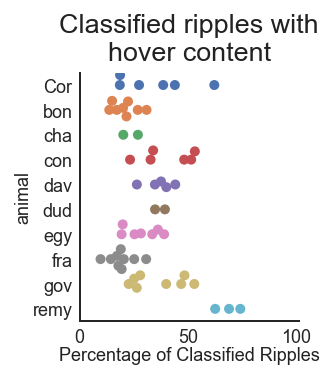

In [8]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(lambda df: (df["Hover"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="animal",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
)
plt.xlim((0, 101))
plt.title("Classified ripples with\nhover content")

Text(0.5, 1, 'Classified ripples with\nhover-continuous-mix content')

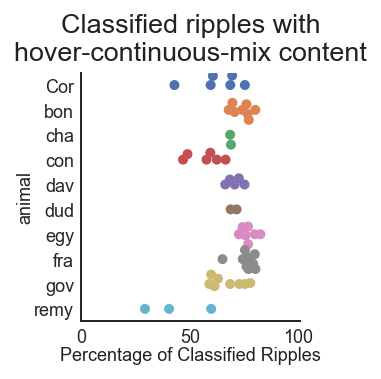

In [10]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(lambda df: (df["Hover-Continuous-Mix"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="animal",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
)
plt.xlim((0, 101))
plt.title("Classified ripples with\nhover-continuous-mix content")

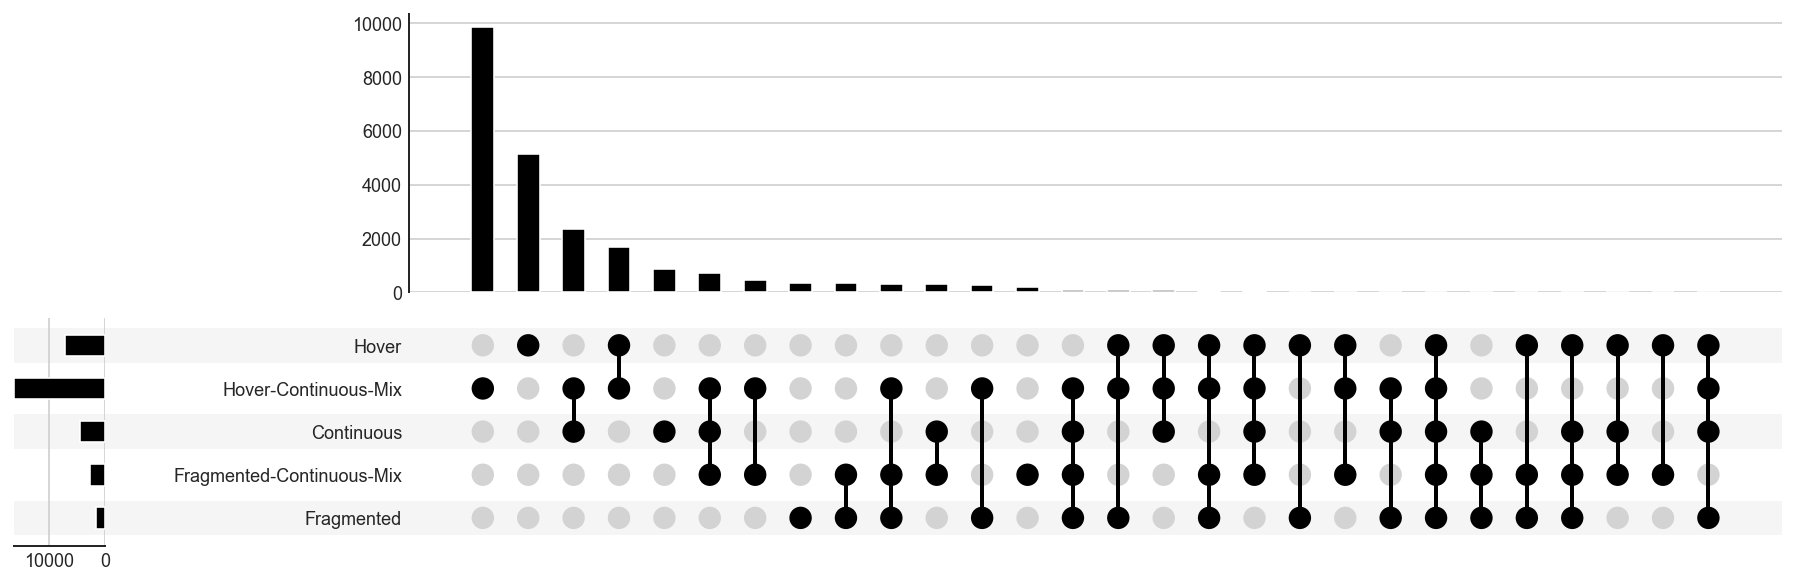

In [33]:
from src.visualization import plot_category_counts

plot_category_counts(replay_info.loc[replay_info.is_classified])
save_figure("figure4_category_counts")

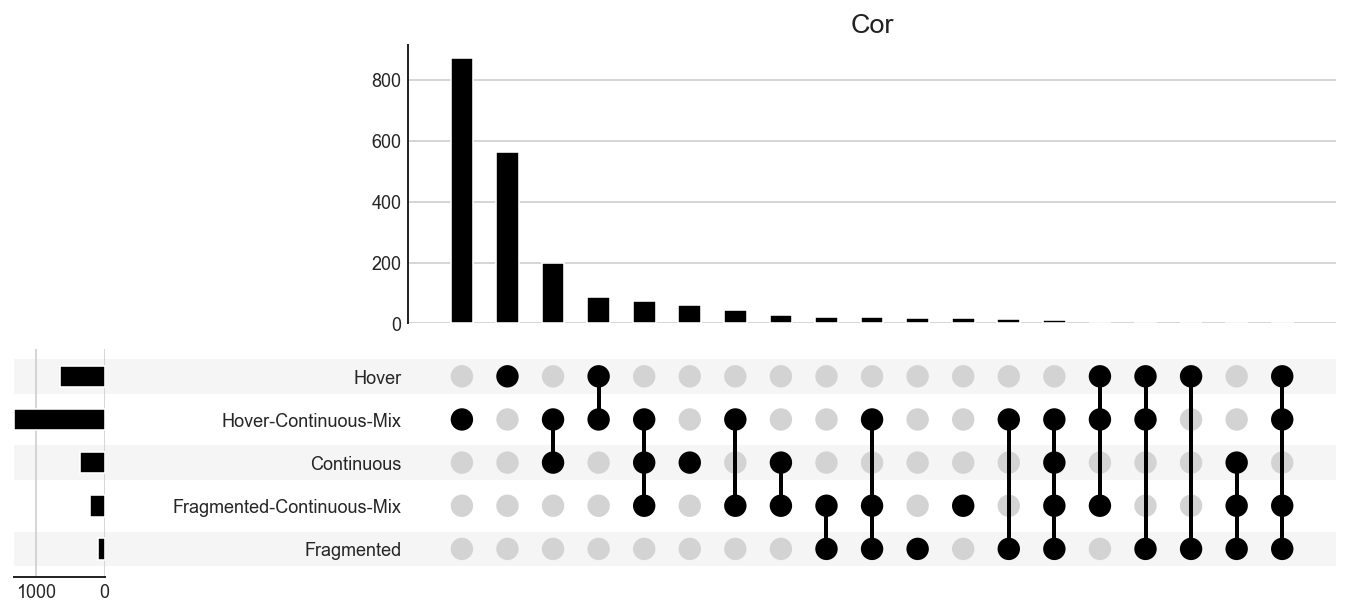

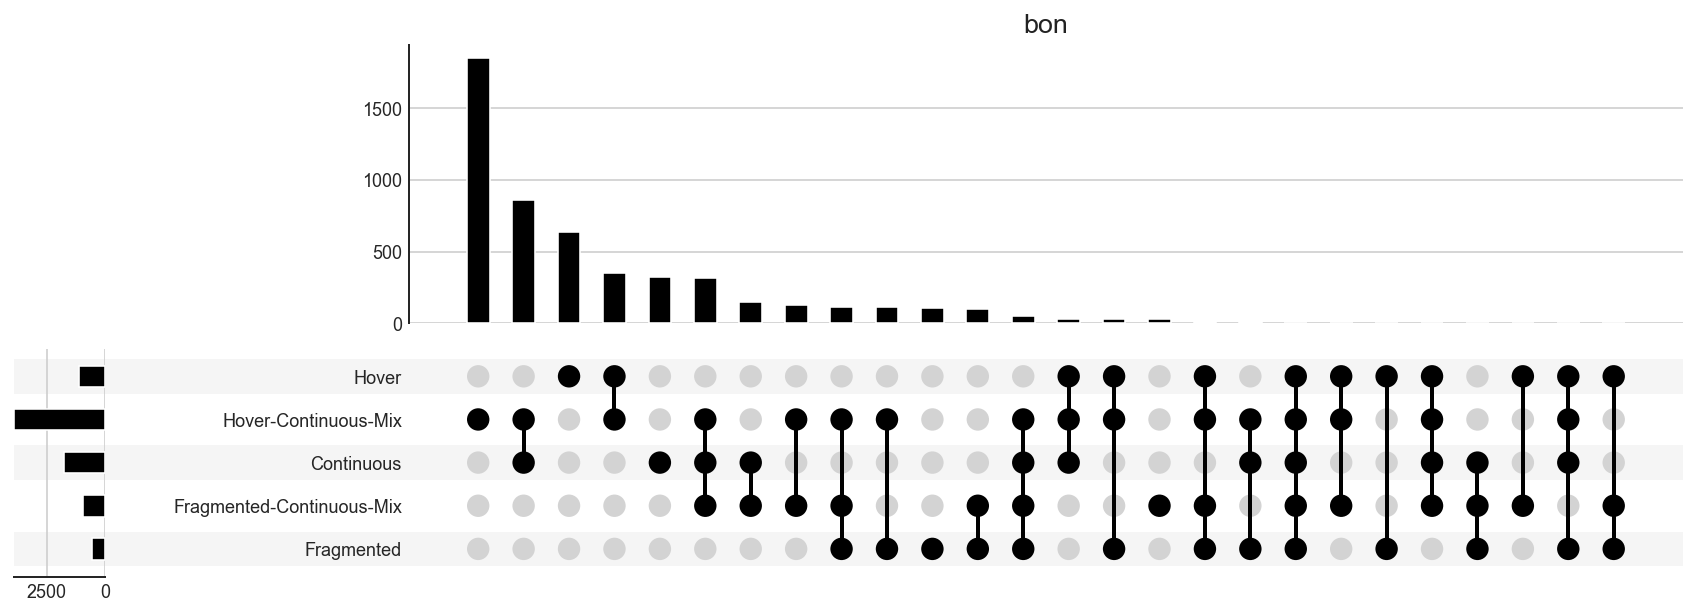

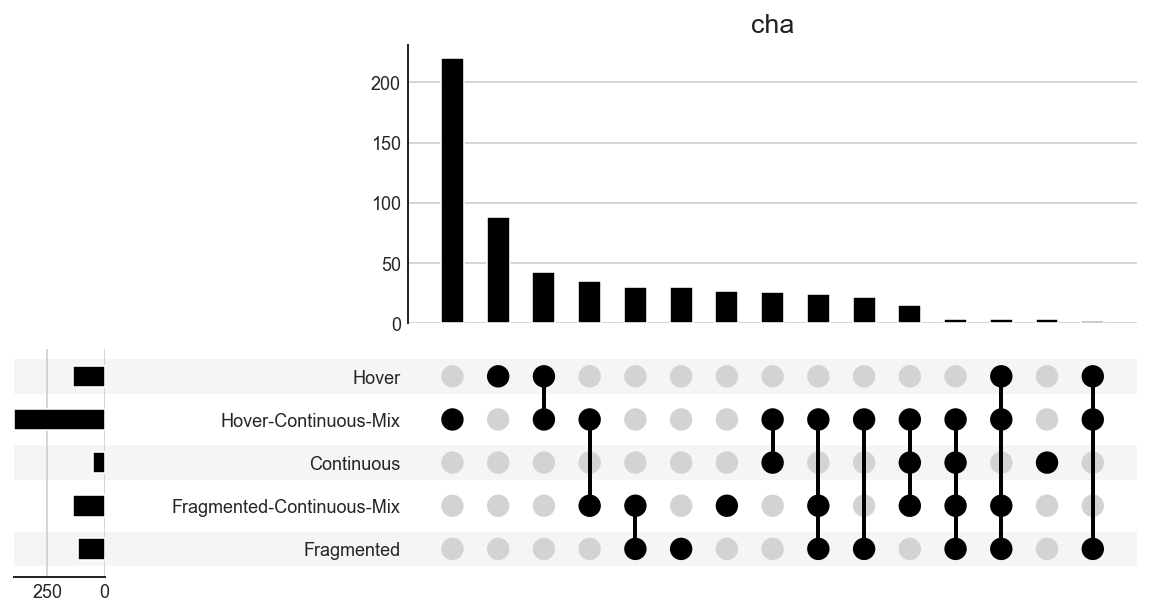

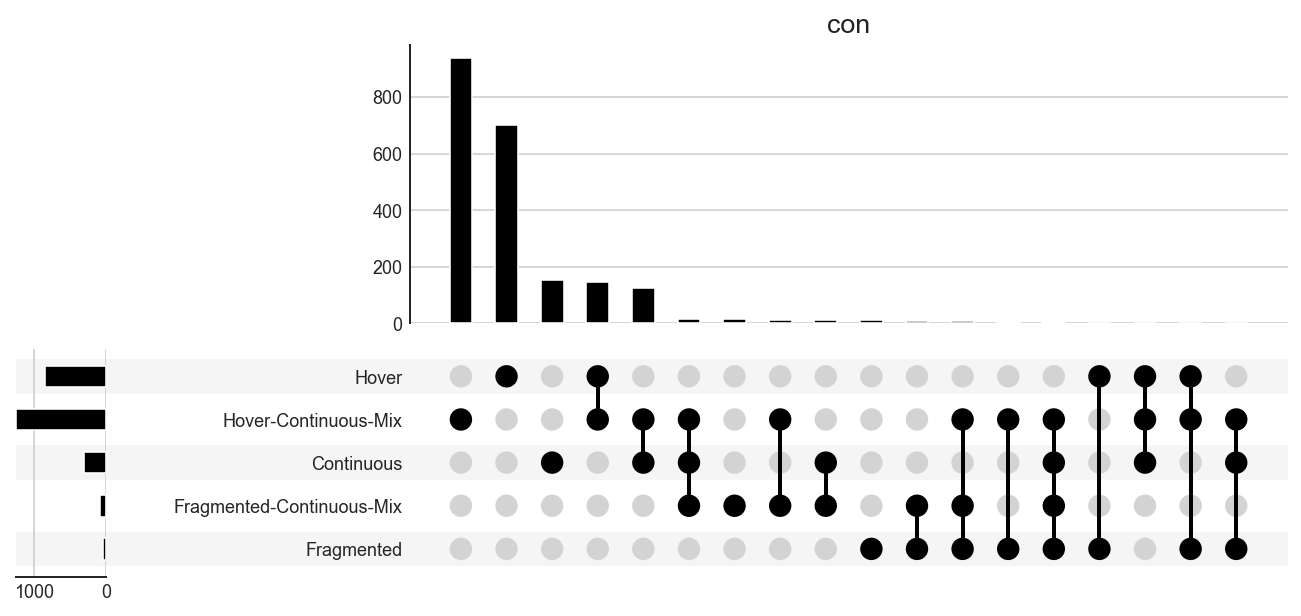

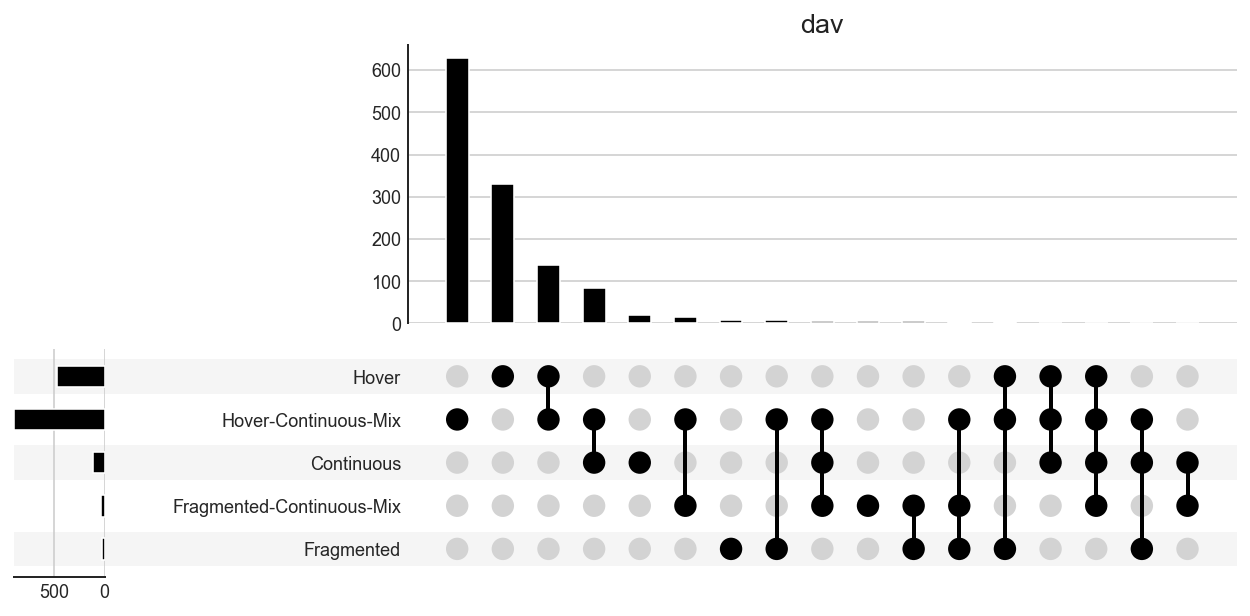

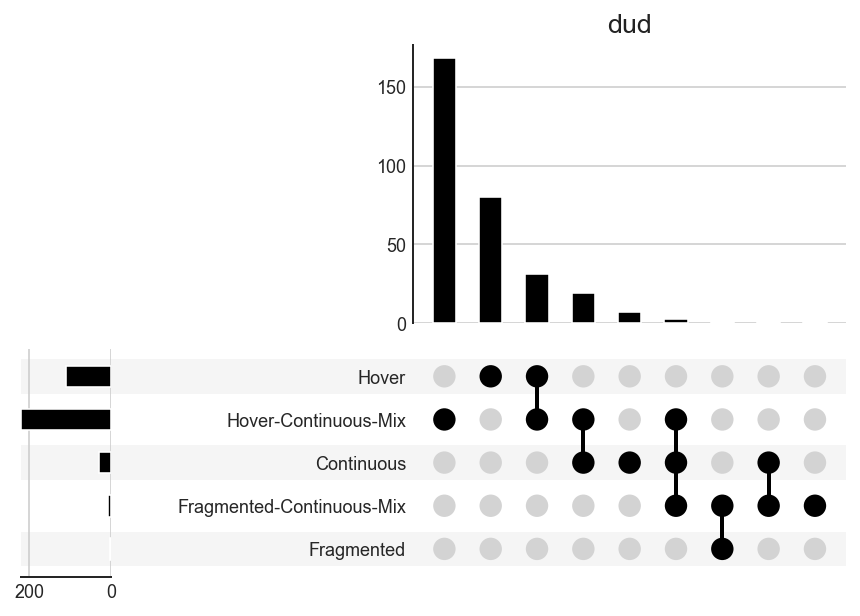

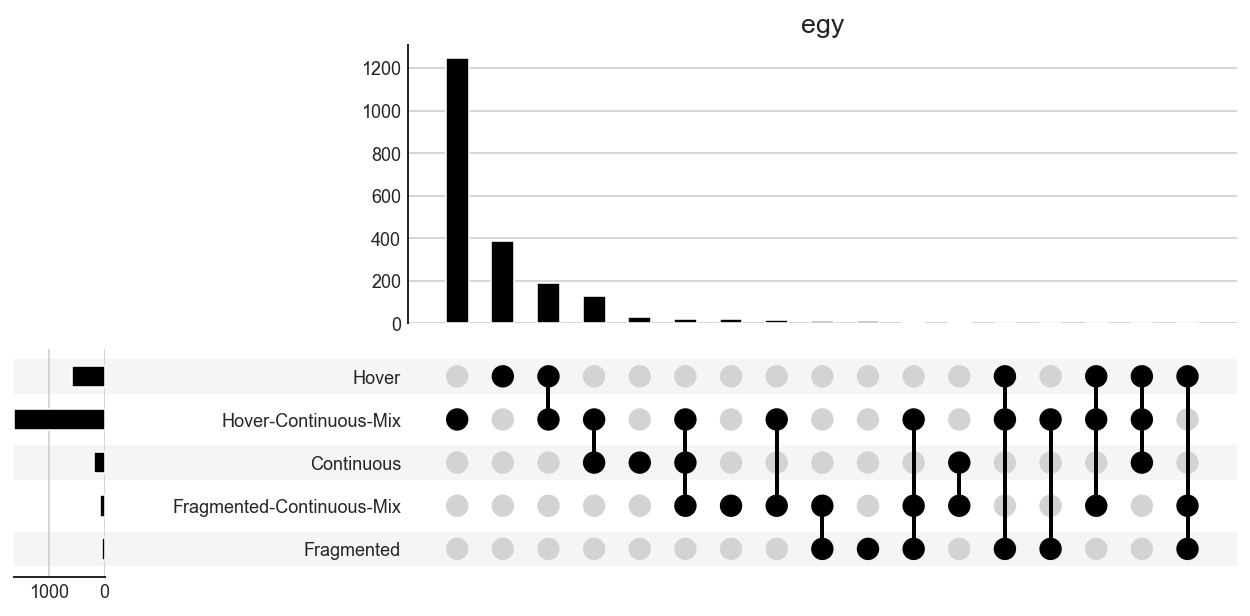

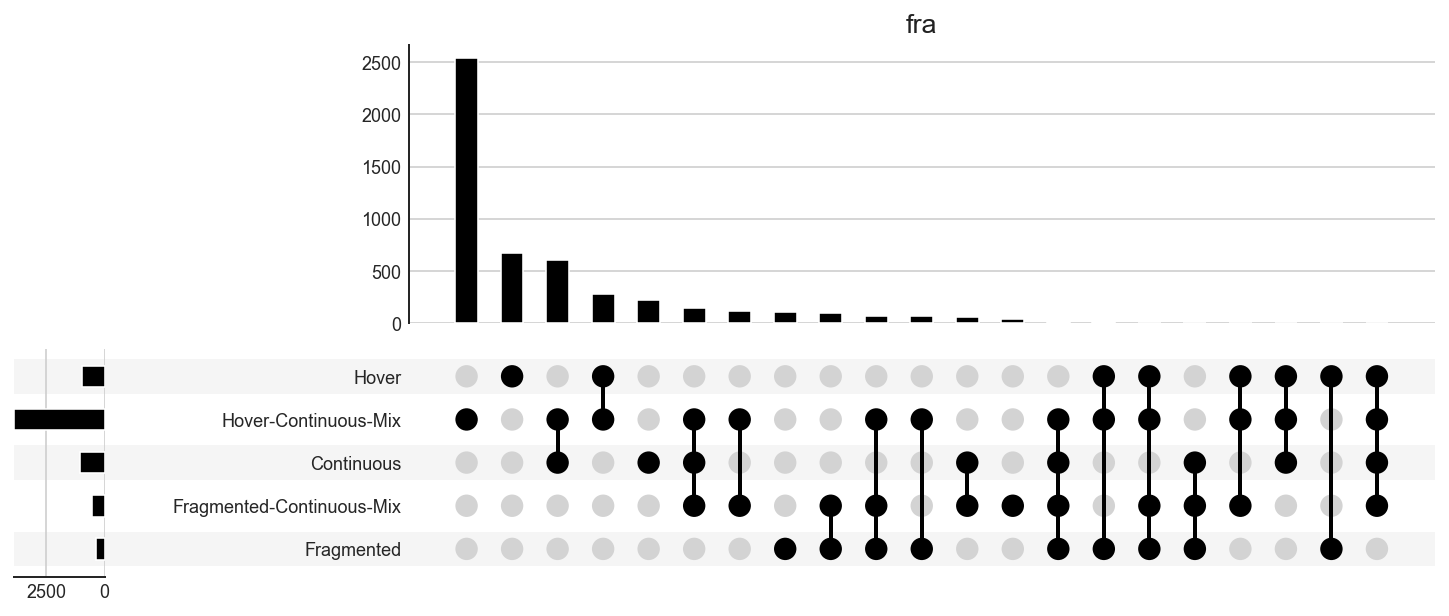

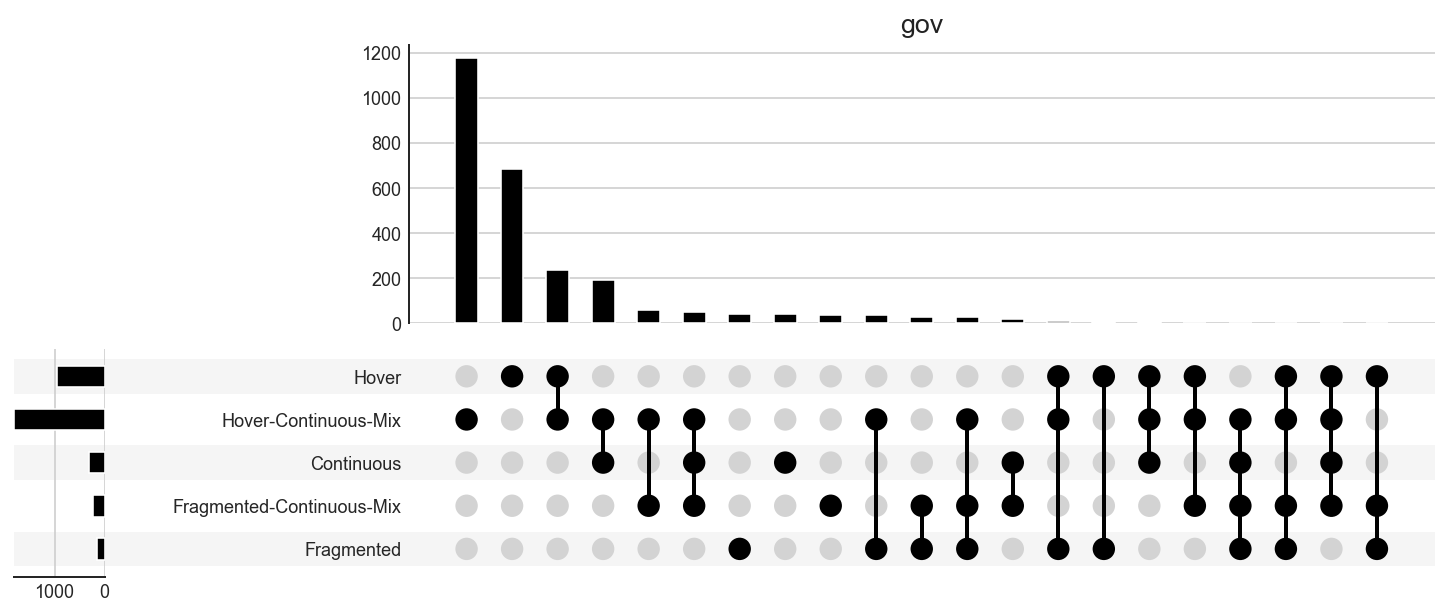

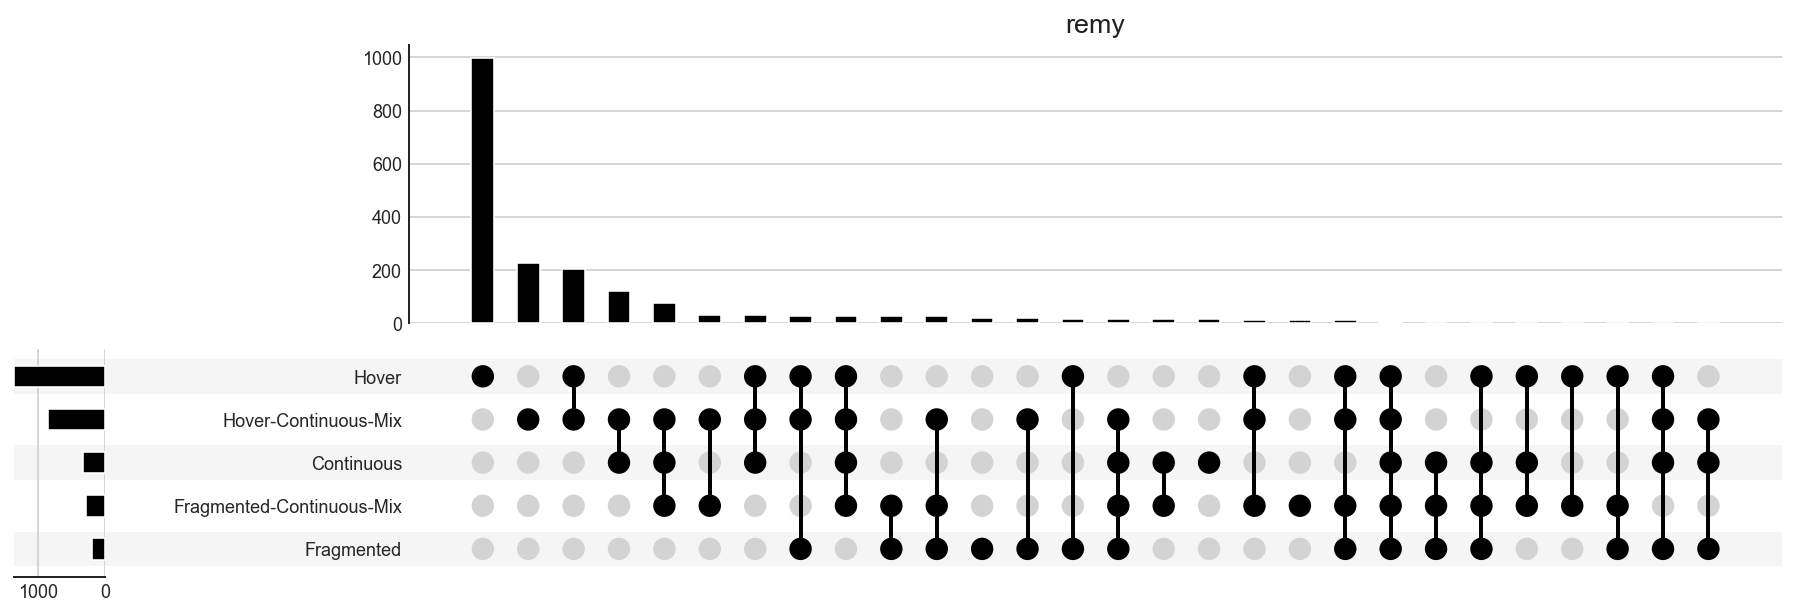

In [38]:
from src.visualization import plot_category_counts

for animal, df in replay_info.groupby("animal"):
    plot_category_counts(df.loc[df.is_classified])
    plt.title(animal)

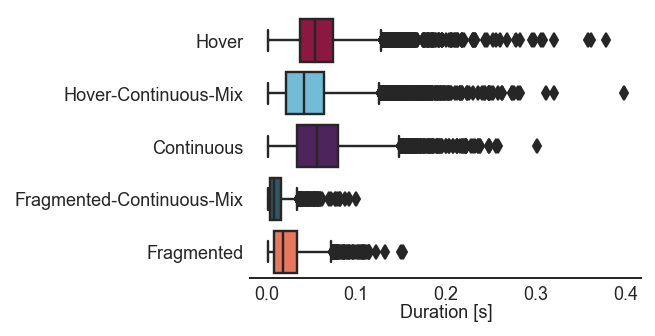

In [45]:
from src.visualization import plot_category_duration

fig, ax = plt.subplots(1, 1, figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 4))
plot_category_duration(replay_info, kind="box", ax=ax)
save_figure("figure4_duration")

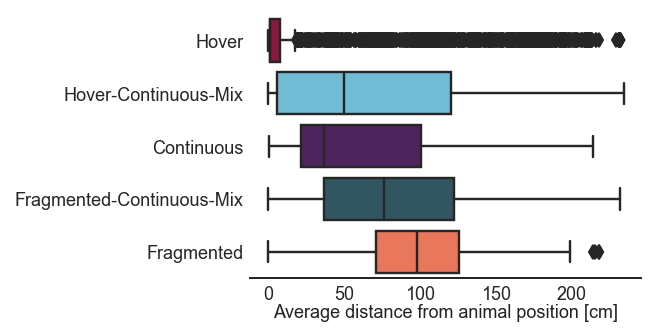

In [59]:
from src.visualization import plot_replay_distance_from_actual_position

fig, ax = plt.subplots(1, 1, figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 4))
plot_replay_distance_from_actual_position(replay_info, kind="box", ax=ax)
save_figure("figure4_average_replay_distance_from_animal")

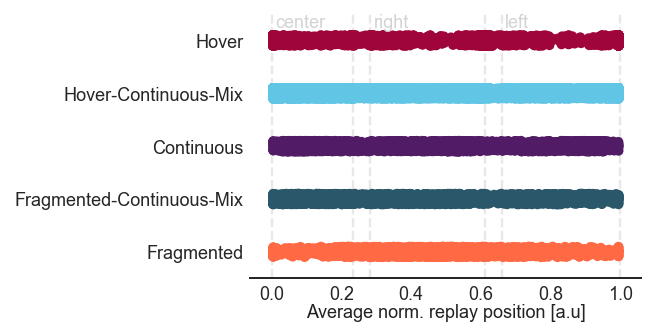

In [62]:
from src.visualization import plot_replay_norm_linear_position

fig, ax = plt.subplots(1, 1, figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 4))
plot_replay_norm_linear_position(replay_info, ax=ax)

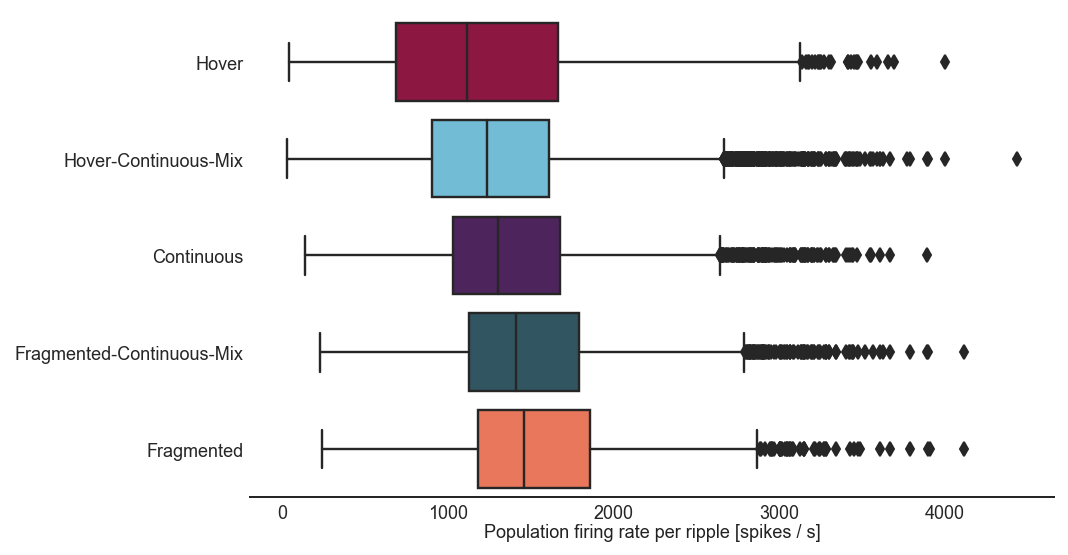

In [68]:
from src.visualization import plot_population_rate

plot_population_rate(replay_info, kind="box")
save_figure("figure4_average_multiunit_rate")

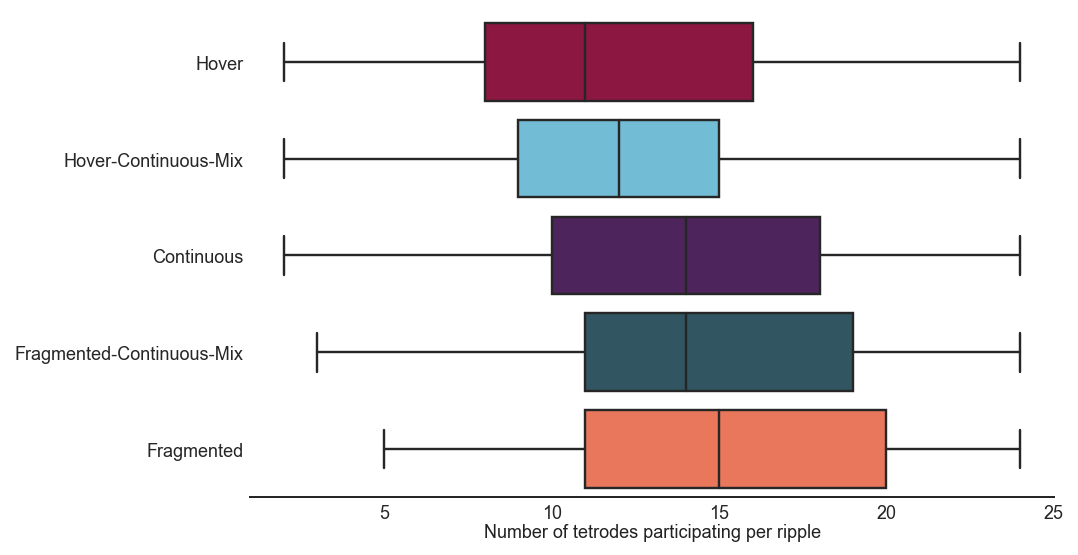

In [72]:
from src.visualization import plot_n_unique_spiking


plt.figure()
plot_n_unique_spiking(replay_info, kind="box", data_type="tetrodes")
save_figure("figure4_n_unique_spiking")

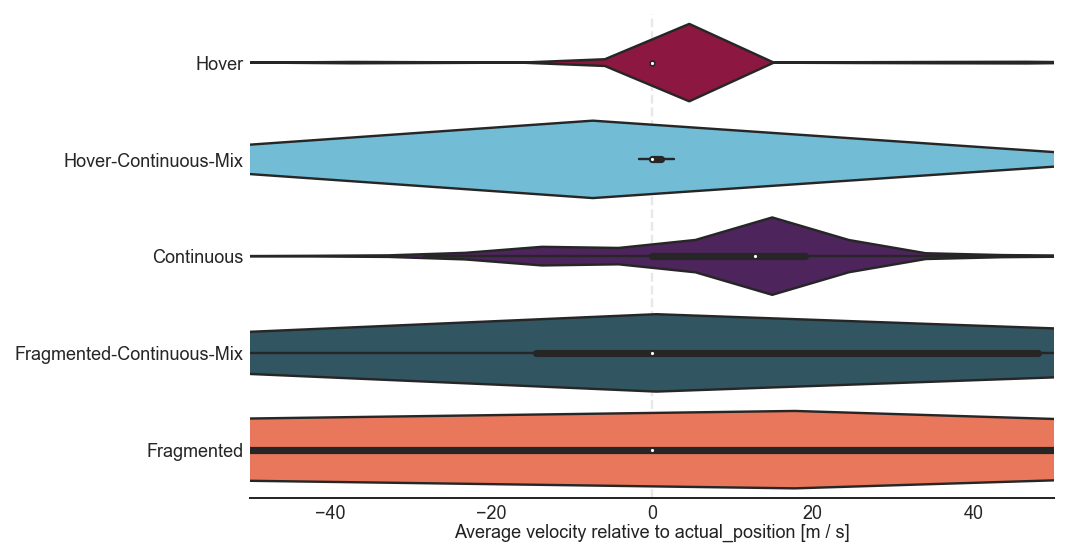

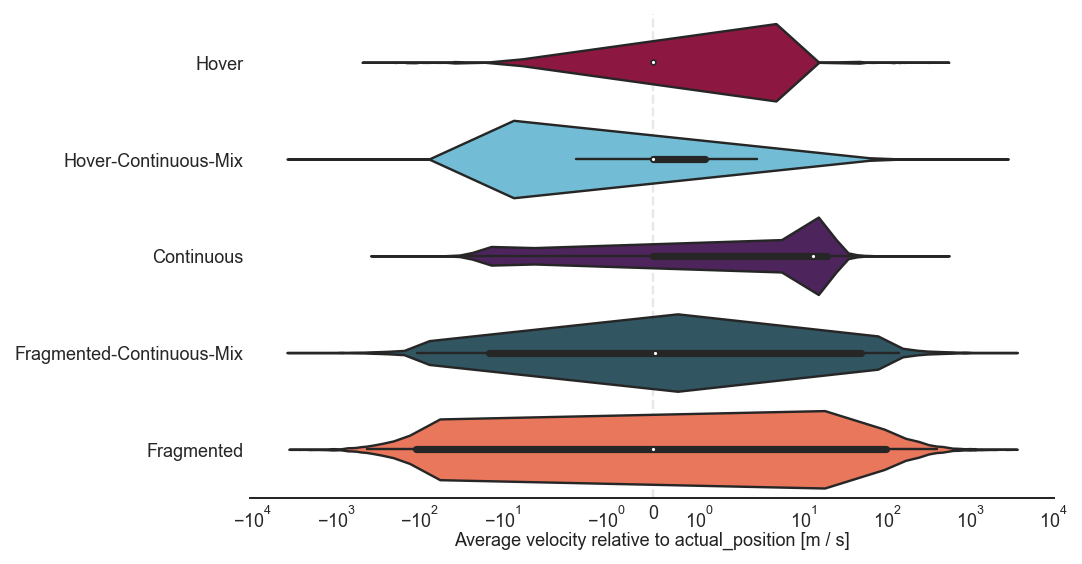

In [46]:
from src.visualization import plot_replay_velocity

plt.figure()
plot_replay_velocity(replay_info, relative_to="actual_position", bw=0.1)
plt.xlim((-50, 50))


plt.figure()
plot_replay_velocity(replay_info, relative_to="actual_position", bw=0.1)
plt.gca().set_xscale("symlog")
save_figure("figure4_replay_velocity_relative_to_animal")

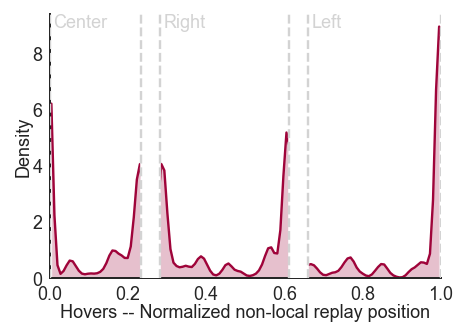

In [107]:
from src.visualization import plot_linear_position_markers

norm_non_local_hover = (
    replay_info.loc[
        replay_info.Hover_replay_distance_from_actual_position > 30
    ].Hover_replay_linear_position.values
    / replay_info.loc[
        replay_info.Hover_replay_distance_from_actual_position > 30
    ].left_well_position
)

fig, ax = plt.subplots(1, 1, figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 4))

sns.kdeplot(
    norm_non_local_hover,
    bw=0.01,
    cut=0,
    shade=True,
    facecolor=STATE_COLORS["Hover"],
    color=STATE_COLORS["Hover"],
    legend=False,
    ax=ax,
)
ax.set_xlabel("Hovers -- Normalized non-local replay position")
ax.set_ylabel("Density")
plot_linear_position_markers(
    replay_info, is_normalized=True, jitter=0.01, zorder=100, alpha=1, ax=ax
)

sns.despine()
ax.set_xlim((0, 1))
save_figure("figure4_hovers_normalized_non_local_replay_position")

In [108]:
len(norm_non_local_hover)

1590

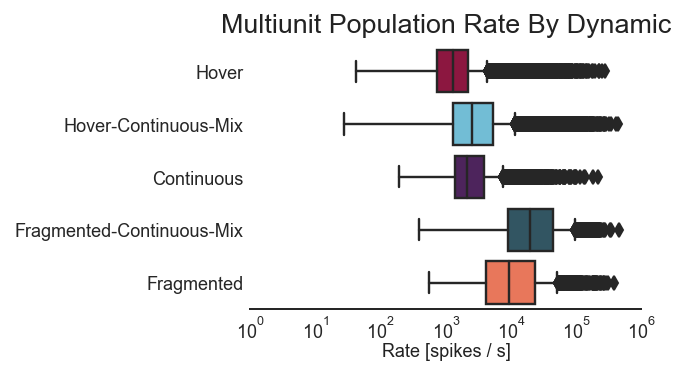

In [137]:
from src.visualization import _plot_category

fig, ax = plt.subplots(1, 1, figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 4))
_plot_category(replay_info, "population_rate", kind="box", ax=ax)
ax.set_xscale("log")
ax.set_xlim((1e0, 1e6))
ax.set_xlabel("Rate [spikes / s]")
ax.set_title("Multiunit Population Rate By Dynamic")
save_figure("figure4_multiunit_population_rate_by_dynamic")

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 4))
